# LA Metro Bike Share Project

Project Goal: The aim of this project is to engineer the end-to-end data flow of bikeshare data (ETL Process)\
Dataset Link: https://bikeshare.metro.net/about/data/

# Import Modules

In [1]:
import os
import warnings
import pandas as pd
from credentials import *
import snowflake.connector
from PIL import Image
from urllib.request import urlopen
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

# Options and Settings

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')

# Load Image

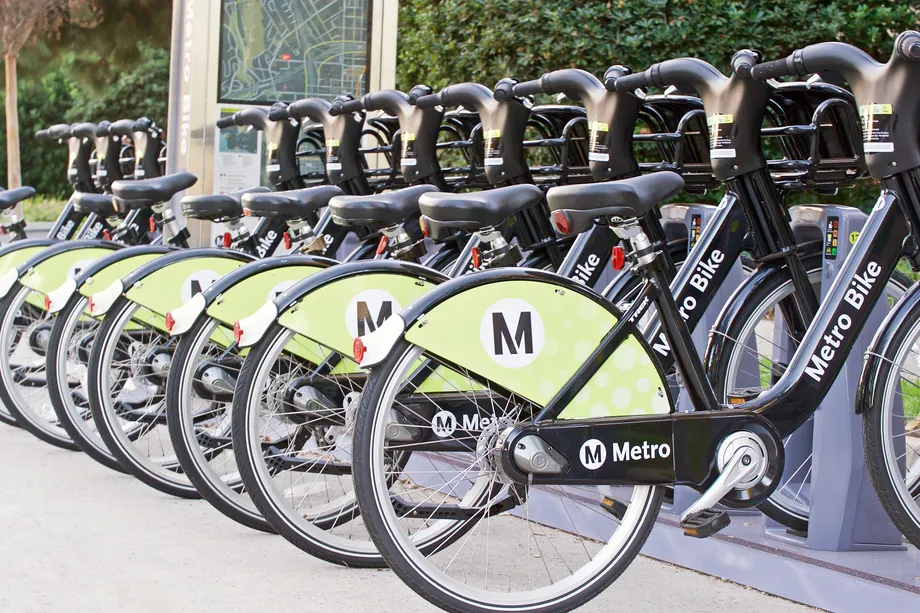

In [3]:
image_url = "https://cdn.vox-cdn.com/thumbor/-znqcrky_BQX7jXguIjp1o78pj0=/0x0:3909x2548/920x613/filters:focal(1643x962:2267x1586):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/60319837/shutterstock_783419776.0.jpg"
Image.open(fp=urlopen(f'{image_url}'))

# Connect To Snowflake

In [4]:
def conn(**db_parameters):
    """
    Connect to Snowflake using the login parameters

    https://github.com/snowflakedb/snowflake-sqlalchemy#escaping-special-characters-such-as---signs-in-passwords

    """
    try:
        engine = create_engine(URL(**db_parameters))
        print("Connection Successful")
        return engine.connect()
    
    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"
    
    finally:
        engine.connect().close()
        engine.dispose()

cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD)

Connection Successful


# Create Data Warehouse

In [5]:
def create_wh(name: str, wh_type: str, size: str, comment: str, is_supended: bool = True):
    """
    Creates a new virtual warehouse in the system.

    https://docs.snowflake.com/en/sql-reference/sql/create-warehouse


    Parameters
    ----------

    name: str
        Identifier for the virtual warehouse; must be unique for your account.
    
    wh_type: str
        Specifies the warehouse type.

    size: str
        Specifies the size of the virtual warehouse.

    comment: str
        Specifies a comment for the warehouse.

    is_supended: bool, defaults to True
        Specifies whether the warehouse is created initially in the 'Suspended' state.

    """   
    create_wh_query = f"""CREATE WAREHOUSE IF NOT EXISTS {name}
                          WAREHOUSE_TYPE = {wh_type}
                          WAREHOUSE_SIZE = {size}
                          INITIALLY_SUSPENDED = {is_supended}
                          COMMENT = '{comment}'

                      """
    try:
        cnx.execute(statement=create_wh_query)
        print(f"{name} warehouse was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"
    
    finally:
        cnx.connect(close_with_result=True)
        

create_wh(name="TRANSFORM_WH", wh_type="STANDARD", size="XSMALL", comment="creates a new virtual warehouse in the system")

TRANSFORM_WH warehouse was created successfully!


# Create Database

In [6]:
def create_db(name: str, comment: str):
    """
    Creates a new database in the system.

    https://docs.snowflake.com/en/sql-reference/sql/create-database


    Parameters
    ----------

    name: str
        Specifies the identifier for the database; must be unique for your account.

    comment: str
        Specifies a comment for the database.

    """   
    create_db_query = f"""CREATE DATABASE IF NOT EXISTS {name}
                          COMMENT = '{comment}'

                       """
    try:
        cnx.execute(statement=create_db_query)
        print(f"{name} database was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


create_db(name="LA_METRO", comment="Creates a new database in the system")

LA_METRO database was created successfully!


# Create Schema

In [7]:
def create_schema(db_name: str, name: str, comment: str):
    """
    Creates a new schema in the current database.

    https://docs.snowflake.com/en/sql-reference/sql/create-schema


    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    comment: str
        Specifies a comment for the schema.

    """   
    create_schema_query = f"""CREATE SCHEMA IF NOT EXISTS {name}
                              COMMENT = '{comment}'

                            """
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name)
        cnx.execute(statement=create_schema_query)
        print(f"{name} schema was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)
         

create_schema(db_name="LA_METRO", name="local", comment="Creates a new schema in the current database")

Connection Successful
local schema was created successfully!


# Create Table

In [8]:
def create_table(db_name: str, schema_name: str, name: str, comment: str):
    """
    Creates a new table in the current/specified schema or replaces an existing table.

    https://docs.snowflake.com/en/sql-reference/sql/create-table


    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    name: str
        Specifies the identifier (i.e. name) for the table; must be unique for the schema in which the table is created.

    comment: str
        Specifies a comment for the column.

    """   
    create_table_query = f"""CREATE OR REPLACE TABLE {name} (
                                                              trip_id INTEGER,
                                                              duration INTEGER,
                                                              start_time TIMESTAMP_NTZ,
                                                              end_time TIMESTAMP_NTZ,
                                                              start_station INTEGER,
                                                              start_lat DECIMAL,
                                                              start_lon DECIMAL,
                                                              end_station INTEGER,
                                                              end_lat DECIMAL,
                                                              end_lon DECIMAL,
                                                              bike_id VARCHAR,
                                                              plan_duration INTEGER,
                                                              trip_route_category VARCHAR,
                                                              passholder_type VARCHAR,
                                                              bike_type VARCHAR
                                                            )
                            COMMENT = '{comment}'

                            """
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=create_table_query)
        print(f"{name} table was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


create_table(db_name="LA_METRO", schema_name="local", name="bikeshare", comment="Creates a new table in the current/specified schema or replaces an existing table.")

Connection Successful
bikeshare table was created successfully!


# Create Stage

In [9]:
def create_stage(db_name: str, schema_name: str, name: str, format_name: str, on_error: str, comment: str, purge: bool = False):
    """
    Creates a new named internal or external stage to use for loading data from files into Snowflake tables and unloading data from tables into files

    https://docs.snowflake.com/en/sql-reference/sql/create-stage

    https://docs.snowflake.com/en/sql-reference/sql/create-stage#label-create-stage-copyoptions


    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    name: str
        Specifies the identifier for the stage; must be unique for the schema in which the stage is created.

    format_name: str
        Specifies the type of files for the stage

    on_error: str
        String (constant) that specifies the error handling for the load operation, defaults to 'ABORT_STATEMENT'

    purge: bool, defaults to 'False'
        Boolean that specifies whether to remove the data files from the stage automatically after the data is loaded successfully.

    comment: str
        Specifies a comment for the stage.

    """   
    create_stage_query = f"""CREATE STAGE IF NOT EXISTS {name}
                             FILE_FORMAT = (TYPE = '{format_name}')
                             COPY_OPTIONS = (ON_ERROR = '{on_error}')
                             COPY_OPTIONS = (PURGE = {purge})
                             COMMENT = '{comment}'

                           """
    
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=create_stage_query)
        print(f"{name} stage was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


create_stage(db_name="LA_METRO", schema_name="local", name="bikeshare_local", format_name="CSV",\
             on_error="ABORT_STATEMENT",
             comment="Creates a new named internal or external stage to use for loading data from files into Snowflake tables"
            )

Connection Successful
bikeshare_local stage was created successfully!


# Upload File

In [10]:
def upload_file(db_name: str, schema_name: str, path_to_file: str, name: str):
    """
    Uploads (i.e. stages) data files from a local directory/folder on a client machine to one of the following Snowflake stages:

    Named internal stage, Internal stage for a specified table, Internal stage for the current user.

    https://docs.snowflake.com/en/sql-reference/sql/put

    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    path_to_file: str
        path_to_file is the local directory path of the file(s) to upload.

    name: str
        Specifies the location in Snowflake where to upload the files

    """   
    upload_file_query = f"""PUT file://{path_to_file} @{name}"""
    
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=upload_file_query)
        print(f"{name} successfully uploaded")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


upload_file(
    db_name="LA_METRO", schema_name="local", 
    path_to_file=os.path.join(os.getcwd(), "Datasets", "MetroBikeShare", "*.csv"), 
    name="bikeshare_local"
)

Connection Successful
bikeshare_local successfully uploaded


# Copy Data from an Internal Location

In [11]:
def load_data(db_name: str, schema_name: str, name: str, stage_name: str):
    """
    Loads data from staged files to an existing table. The files must already be staged in one of the following locations

    https://docs.snowflake.com/en/sql-reference/sql/copy-into-table

    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    name: str
        Specifies the name of the table into which data is loaded.

    stage_name: str
        Specifies the identifier for the stage; must be unique for the schema in which the stage is created.

    """   
    load_data_query = f"""COPY INTO {name}
                          FROM @{stage_name}
                          
                       """
    
    try:
        cnx= conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=load_data_query)
        print(f"Data successfully loaded into {name} table")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


load_data(db_name="LA_METRO", schema_name="local", name="bikeshare", stage_name="bikeshare_local")

Connection Successful
Data successfully loaded into bikeshare table


# Query Table

In [12]:
db_name = "LA_METRO"
schema_name = "local"
table_name = "bikeshare"

cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
results = cnx.execute(f"""SELECT DISTINCT * FROM {table_name}""").fetchall()

df = pd.DataFrame(results)

Connection Successful


# View Data

In [13]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,231801471,97,2023-01-01 01:05:00,2023-01-01 02:42:00,3054,34.0,-118.0,3054,34.0,-118.0,13870,1,Round Trip,Walk-up,standard
1,231794664,26,2023-01-01 01:31:00,2023-01-01 01:57:00,3063,34.0,-118.0,4454,34.0,-118.0,22873,1,One Way,Walk-up,electric
2,231801466,36,2023-01-01 02:08:00,2023-01-01 02:44:00,4487,34.0,-118.0,4209,34.0,-118.0,5991,1,One Way,Walk-up,standard
3,231801465,11,2023-01-01 02:31:00,2023-01-01 02:42:00,3030,34.0,-118.0,4540,34.0,-118.0,6145,1,One Way,Walk-up,standard
4,231801464,10,2023-01-01 02:31:00,2023-01-01 02:41:00,3030,34.0,-118.0,4540,34.0,-118.0,6408,1,One Way,Walk-up,standard


In [14]:
df.tail()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
181660,276478505,10,2023-06-30 16:32:00,2023-06-30 16:42:00,3027,34.0,-118.0,3000,NaN,NaN,15314,30,One Way,Monthly Pass,standard
181661,276531151,44,2023-06-30 17:21:00,2023-06-30 18:05:00,4214,34.0,-118.0,4215,34.0,-118.0,19585,1,One Way,Walk-up,electric
181662,276547974,80,2023-06-30 18:08:00,2023-06-30 19:28:00,4214,34.0,-118.0,4214,34.0,-118.0,13373,1,Round Trip,Walk-up,standard
181663,276532177,4,2023-06-30 18:13:00,2023-06-30 18:17:00,4516,34.0,-118.0,3005,34.0,-118.0,26866,30,One Way,Monthly Pass,electric
181664,276550167,33,2023-06-30 19:36:00,2023-06-30 20:09:00,4214,34.0,-118.0,4214,34.0,-118.0,13993,1,Round Trip,Walk-up,standard


# Copy Data from an External Location

Create Storage Integration

In [15]:
def create_integration(db_name: str, schema_name: str, name: str, storage_provider: str, storage_aws_role_arn: str, storage_allowed_locations: str, comment: str):
    """
    Creates a new storage integration in the account or replaces an existing integration.

    https://docs.snowflake.com/en/sql-reference/sql/create-storage-integration

    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    name: str
        String that specifies the identifier (i.e. name) for the integration; must be unique in your account.

    storage_provider: str
        Specifies the cloud storage provider that stores your data files

    storage_aws_role_arn: str
        Specifies the Amazon Resource Name (ARN) of the AWS identity and access management (IAM) role that grants privileges 
        on the S3 bucket containing your data files.

    storage_allowed_locations: str
        Explicitly limits external stages that use the integration to reference one or more storage locations (i.e. S3 bucket, GCS bucket, or Azure container).

    comment: str
        String (literal) that specifies a comment for the integration.

    """   
    create_storage_integration_query = f"""
                                        CREATE STORAGE INTEGRATION IF NOT EXISTS {name}
                                        TYPE = EXTERNAL_STAGE
                                        STORAGE_PROVIDER = '{storage_provider}'
                                        STORAGE_AWS_ROLE_ARN = '{storage_aws_role_arn}'
                                        ENABLED = TRUE
                                        STORAGE_ALLOWED_LOCATIONS = ('{storage_allowed_locations}')
                                        COMMENT = '{comment}'

                                        """
    
    grant_access_query = f"""
                          GRANT USAGE ON INTEGRATION {name} TO ROLE {ROLE}

                          """
    
    try:
        cnx = conn(account=ACCOUNT, user=USER, password=PASSWORD, database=db_name, schema=schema_name, warehouse=WAREHOUSE, role=ROLE)
        cnx.execute(statement=create_storage_integration_query)
        cnx.execute(statement=grant_access_query)
        print(f"Storage Integration '{name}' created successfully")
        print(f"Access successfully granted to {ROLE}")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


create_integration(
                    db_name="LA_METRO", schema_name="public", name="Amazon_S3", storage_provider="S3", storage_aws_role_arn=AWS_ROLE_ARN, 
                    storage_allowed_locations=S3_BUCKET_NAME, comment="Creates a new storage integration in the account or replace an existing integration" 
)

Connection Successful
Storage Integration 'Amazon_S3' created successfully
Access successfully granted to ACCOUNTADMIN


# Create External Stage

In [16]:
def create_external_stage(db_name: str, schema_name: str, stage_name: str, integration_name: str, storage_allowed_locations: str, format_name: str, on_error: str, comment: str, purge: bool = False):
    """
    Creates a new named internal or external stage to use for loading data from files into Snowflake tables and unloading data from tables into files

    https://docs.snowflake.com/en/sql-reference/sql/create-stage

    https://docs.snowflake.com/en/sql-reference/sql/create-stage#label-create-stage-copyoptions


    Parameters
    ----------

    db_name: str
        Specifies the identifier for the database; must be unique for your account.

    schema_name: str
        Specifies the identifier for the schema; must be unique for the database in which the schema is created.

    stage_name: str
        Specifies the identifier for the stage; must be unique for the schema in which the stage is created.

    integration_name: str
        String that specifies the identifier (i.e. name) for the integration; must be unique in your account.

    storage_allowed_locations: str
        Explicitly limits external stages that use the integration to reference one or more storage locations (i.e. S3 bucket, GCS bucket, or Azure container).

    format_name: str
        Specifies the type of files for the stage

    on_error: str
        String (constant) that specifies the error handling for the load operation, defaults to 'ABORT_STATEMENT'

    purge: bool, defaults to 'False'
        Boolean that specifies whether to remove the data files from the stage automatically after the data is loaded successfully.

    comment: str
        Specifies a comment for the stage.

    """   
    create_external_stage_query = f"""CREATE STAGE IF NOT EXISTS {stage_name}
                                      STORAGE_INTEGRATION = {integration_name}
                                      URL = '{storage_allowed_locations}'
                                      FILE_FORMAT = (TYPE = '{format_name}')
                                      COPY_OPTIONS = (ON_ERROR = '{on_error}')
                                      COPY_OPTIONS = (PURGE = {purge})
                                      COMMENT = '{comment}'

                                   """
    
    try:
        cnx = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
        cnx.execute(statement=create_external_stage_query)
        print(f"External stage '{stage_name}' was created successfully!")

    except snowflake.connector.errors.ProgrammingError as e:
        return f"An error occurred: {e}"

    finally:
         cnx.connect(close_with_result=True)


create_external_stage(
    db_name="LA_METRO", schema_name="public", stage_name="AWS_Cloud", integration_name="Amazon_S3", storage_allowed_locations=S3_BUCKET_NAME, format_name="CSV", 
    on_error="ABORT_STATEMENT", comment="Creates a new named internal or external stage to use for loading data from files into Snowflake tables"
)

Connection Successful
External stage 'AWS_Cloud' was created successfully!


# Create Table

In [17]:
create_table(db_name="LA_METRO", schema_name="public", name="bikeshare", comment="Creates a new table in the current/specified schema or replaces an existing table.")

Connection Successful
bikeshare table was created successfully!


# Load Data

In [18]:
load_data(db_name="LA_METRO", schema_name="public", name="bikeshare", stage_name="AWS_Cloud")

Connection Successful
Data successfully loaded into bikeshare table


# Query Table

In [19]:
schema_name = "public"

cnx_aws = conn(account=ACCOUNT, role=ROLE, user=USER, password=PASSWORD, database=db_name, schema=schema_name)
results_aws = cnx_aws.execute(f"""SELECT DISTINCT * FROM {table_name}""").fetchall()

df1 = pd.DataFrame(results_aws)

Connection Successful


# View Data

In [20]:
df1.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,231801471,97,2023-01-01 01:05:00,2023-01-01 02:42:00,3054,34.0,-118.0,3054,34.0,-118.0,13870,1,Round Trip,Walk-up,standard
1,231794664,26,2023-01-01 01:31:00,2023-01-01 01:57:00,3063,34.0,-118.0,4454,34.0,-118.0,22873,1,One Way,Walk-up,electric
2,231801466,36,2023-01-01 02:08:00,2023-01-01 02:44:00,4487,34.0,-118.0,4209,34.0,-118.0,5991,1,One Way,Walk-up,standard
3,231801465,11,2023-01-01 02:31:00,2023-01-01 02:42:00,3030,34.0,-118.0,4540,34.0,-118.0,6145,1,One Way,Walk-up,standard
4,231801464,10,2023-01-01 02:31:00,2023-01-01 02:41:00,3030,34.0,-118.0,4540,34.0,-118.0,6408,1,One Way,Walk-up,standard


In [21]:
df1.tail()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
181660,276478505,10,2023-06-30 16:32:00,2023-06-30 16:42:00,3027,34.0,-118.0,3000,NaN,NaN,15314,30,One Way,Monthly Pass,standard
181661,276531151,44,2023-06-30 17:21:00,2023-06-30 18:05:00,4214,34.0,-118.0,4215,34.0,-118.0,19585,1,One Way,Walk-up,electric
181662,276547974,80,2023-06-30 18:08:00,2023-06-30 19:28:00,4214,34.0,-118.0,4214,34.0,-118.0,13373,1,Round Trip,Walk-up,standard
181663,276532177,4,2023-06-30 18:13:00,2023-06-30 18:17:00,4516,34.0,-118.0,3005,34.0,-118.0,26866,30,One Way,Monthly Pass,electric
181664,276550167,33,2023-06-30 19:36:00,2023-06-30 20:09:00,4214,34.0,-118.0,4214,34.0,-118.0,13993,1,Round Trip,Walk-up,standard
